In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [8]:
# Time in UTC
start = "2023-10-17 04:00:00.000"
end = "2023-11-01 09:00:00.000"
selector = ['CPS.USER.MD3']

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build()
spills = spills.filter(spills.selector.isin(selector)).toPandas()

# Convert the 'acqStamp' column to datetime and create a new column
spills['timestamp'] = pd.to_datetime(spills['acqStamp'], unit='ns')
spills['intensity'] = spills['semSpillData'].apply(lambda x: abs(sum(x['elements'])))

# def calculate_flux(row):
#     if row['selector'] == 'CPS.USER.EAST3':
#         return abs(row["semSpillData"]["elements"].sum())*78.5/400 + 398.6
#     elif row['selector'] == 'CPS.USER.MD5':
#         return abs(row["semSpillData"]["elements"].sum())*34.4/400 + 58.4
#     elif row['selector'] == 'CPS.USER.EAST4':
#         return abs(row["semSpillData"]["elements"].sum())*125/400 + 0.0
#     else:
#         return np.nan

# spills['flux'] = spills.apply(calculate_flux, axis=1)

spills_sorted = spills.sort_values(by='timestamp')

# Merge with the gain dataframe
# merge_df = pd.merge_asof(spills_sorted, gain_df, on='timestamp', direction='nearest')
# df = merge_df[['timestamp','selector', 'flux', 'gain','intensity']]

# calculate the difference in time (in seconds) and 'gain' between each row
# df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
# df['gain_diff'] = df['gain'].diff()

In [9]:
df = spills_sorted[['timestamp', 'intensity']]
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

/tmp/ipykernel_591/4166894710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff'] = df['timestamp'].diff().dt.total_seconds()


In [10]:
# gain = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PR.BQL72/SummaryAcquisition").build()

gain = ParameterDataQuery.builder(spark).system('CMW').parameterEq('PR.BQL72/SummaryAcquisition').timeWindow(start, end).build()

gain = gain.select("acqStamp","exAmplitudeH").where(f"selector = 'CPS.USER.MD3'").toPandas()
gain['timestamp'] = pd.to_datetime(gain['acqStamp'], unit='ns')
gain = gain.sort_values(by='timestamp')

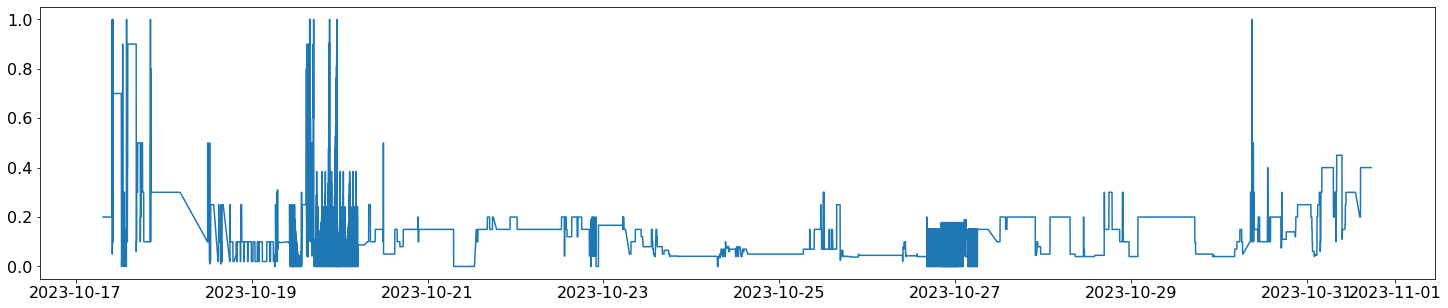

In [11]:
fig, ax = plt.subplots(figsize=(25,5))
ax.plot(gain.timestamp, gain.exAmplitudeH)

In [21]:
merge_df = pd.merge_asof(spills_sorted, gain, on='timestamp', direction='nearest')
df = merge_df[['timestamp', 'exAmplitudeH','intensity']]
df = df.rename(columns={'exAmplitudeH': 'gain'}).copy()

df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['gain_diff'] = df['gain'].diff()

In [22]:
df.head(5)

timestamp  gain  intensity  time_diff  gain_diff
0 2023-10-17 07:29:52.851   0.2        107        NaN        NaN
1 2023-10-17 07:30:50.451   0.2         23       57.6        0.0
2 2023-10-17 07:31:48.051   0.2         34       57.6        0.0
3 2023-10-17 07:32:45.651   0.2         65       57.6        0.0
4 2023-10-17 07:39:15.651   0.2         40      390.0        0.0

Text(0.5, 0, 'Timestamp')

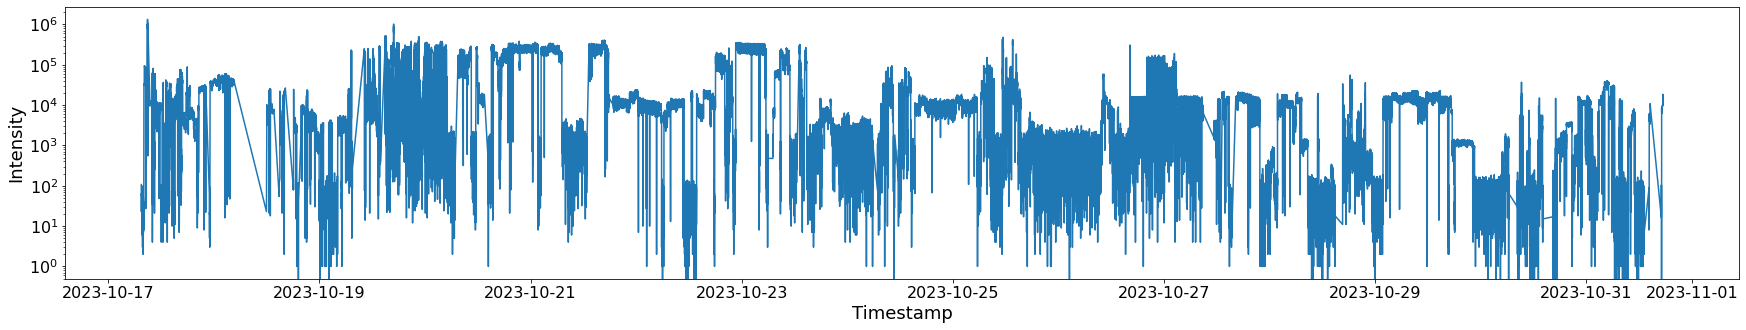

In [32]:
fig, ax = plt.subplots(figsize=(30, 5))

ax.plot(df.timestamp, df.intensity)
ax.set_yscale("log")
ax.set_ylabel("Intensity")
ax.set_xlabel("Timestamp")

Text(0.5, 0, 'RFKO gain')

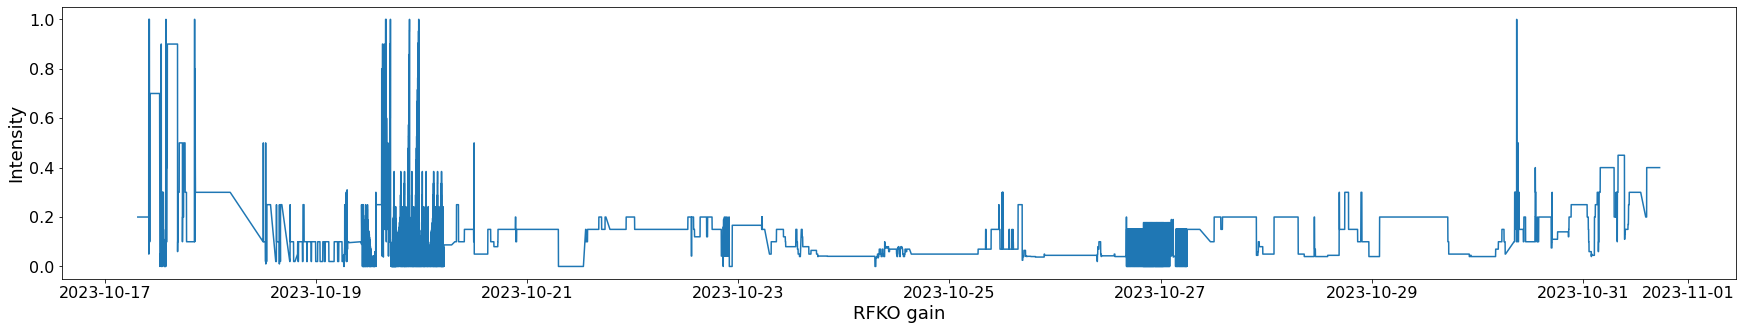

In [31]:
fig, ax = plt.subplots(figsize=(30, 5))

ax.plot(df.timestamp, df.gain)
ax.set_ylabel("Intensity")
ax.set_xlabel("RFKO gain")

Text(0.5, 0, 'RFKO gain')

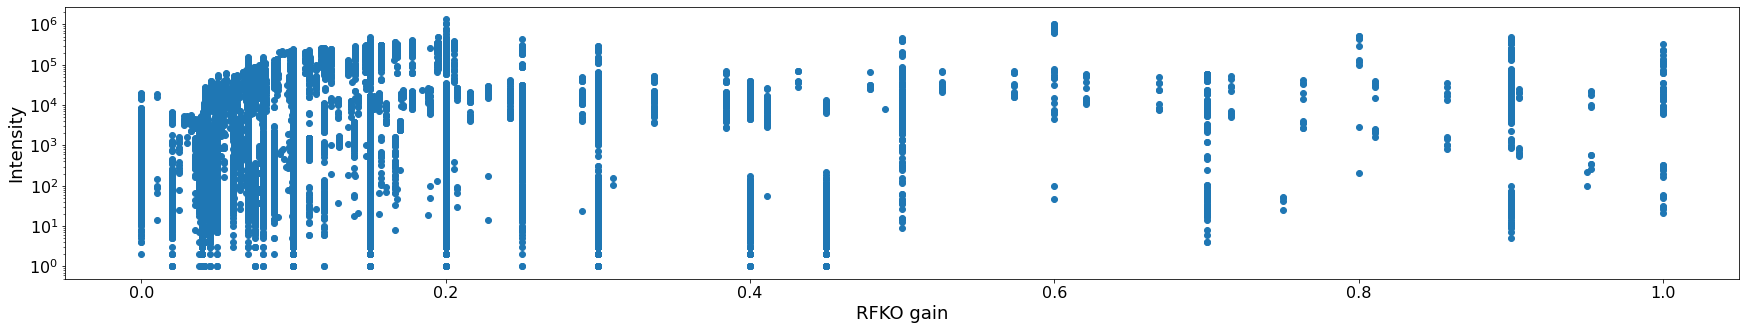

In [29]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.scatter(df.gain, df.intensity)
ax.set_yscale("log")
ax.set_ylabel("Intensity")
ax.set_xlabel("RFKO gain")

In [41]:
df_gain_intensity = df.copy()

In [42]:
df_gain_intensity

timestamp  gain  intensity  time_diff  gain_diff
0     2023-10-17 07:29:52.851   0.2        107        NaN        NaN
1     2023-10-17 07:30:50.451   0.2         23       57.6        0.0
2     2023-10-17 07:31:48.051   0.2         34       57.6        0.0
3     2023-10-17 07:32:45.651   0.2         65       57.6        0.0
4     2023-10-17 07:39:15.651   0.2         40      390.0        0.0
...                       ...   ...        ...        ...        ...
76237 2023-10-31 17:27:20.541   0.4      16365        3.6        0.0
76238 2023-10-31 17:27:24.141   0.4      16496        3.6        0.0
76239 2023-10-31 17:27:27.741   0.4      16896        3.6        0.0
76240 2023-10-31 17:27:31.341   0.4      14267        3.6        0.0
76241 2023-10-31 17:27:34.941   0.4      15472        3.6        0.0

[76242 rows x 5 columns]

# B-field

In [43]:
df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PR.BMEAS-B-ST/CycleSamples").build()
df = df.filter(df.selector.isin(selector)).toPandas()
df['avg_flattop_Gauss'] = df['samples'].apply(lambda x: round(np.mean(x["elements"][1000:1500]), 1)) # Hardcoded flattop time
df['Ekin'] = df['avg_flattop_Gauss'].apply(lambda x: (193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/x))/193.737692)**2+1)-1), 1) # Hardcoded flattop time
# Add a column with timestamp in datetime format
df["timestamp"] = pd.to_datetime(df['acqStamp'], unit='ns')
df.sort_values(by="timestamp", inplace=True)
df = df[df.selector == selector].reset_index(drop=True)

23/11/13 09:20:57 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/11/13 09:22:55 ERROR TaskSetManager: Total size of serialized results of 1559 tasks (1026.0 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 774.0 in stage 10.0 (TID 1969) (ithdp2003.cern.ch executor 28): TaskKilled (Tasks result size has exceeded maxResultSize)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 839.0 in stage 10.0 (TID 2033) (ithdp2003.cern.ch executor 28): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 1072.0 in stage 10.0 (TID 2147) (ithdp1064.cern.ch executor 21): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 722.0 in stage 10.0 (TID 1938) (ithdp2003.cern.ch executor 28): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 895.0 in stage 10.

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro_pytimber_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/pandas/conversion.py:201: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o187.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:97)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:93)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.int

Py4JJavaError: An error occurred while calling o187.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:97)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:93)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 1559 tasks (1026.0 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2323)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:3798)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:3802)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:3779)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:3779)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:3778)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:139)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:141)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:136)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:113)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:107)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:68)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:68)


23/11/13 09:22:55 WARN TaskSetManager: Lost task 877.0 in stage 10.0 (TID 2055) (ithdp1057.cern.ch executor 23): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 799.0 in stage 10.0 (TID 1979) (ithdp2003.cern.ch executor 24): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 1229.0 in stage 10.0 (TID 2010) (ithdp-nxcals6006.cern.ch executor 25): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 851.0 in stage 10.0 (TID 2039) (ithdp2003.cern.ch executor 24): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 1075.0 in stage 10.0 (TID 1994) (ithdp-nxcals6006.cern.ch executor 25): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 815.0 in stage 10.0 (TID 2013) (ithdp2003.cern.ch executor 24): TaskKilled (Stage cancelled)
23/11/13 09:22:55 WARN TaskSetManager: Lost task 810.0 in stage 10.0 (TID 2005) (ithdp2003.cern.ch executor 24): TaskKilled (Stage c

In [52]:
from pyspark.sql import functions as F

# Function to retrieve data in smaller chunks
def get_data_in_chunks(start, end, chunk_size='2 days'):
    current_start = start
    current_end = current_start + pd.Timedelta(chunk_size)

    dfs = []  # List to hold the chunks of DataFrames
    while current_start < end:
        temp_df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(current_start).endTime(current_end).entity().parameter("PR.BMEAS-B-ST/CycleSamples").build()
        temp_df = temp_df.filter(temp_df.selector.isin(selector)).toPandas()
        temp_df['avg_flattop_Gauss'] = temp_df['samples'].apply(lambda x: round(np.mean(x["elements"][1000:1500]), 1)) # Hardcoded flattop time
        temp_df['Ekin'] = temp_df['avg_flattop_Gauss'].apply(lambda x: (193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/x))/193.737692)**2+1)-1), 1) # Hardcoded flattop time
        # Add a column with timestamp in datetime format
        temp_df["timestamp"] = pd.to_datetime(temp_df['acqStamp'], unit='ns')
        temp_df.sort_values(by="timestamp", inplace=True)
        temp_df = temp_df[temp_df.selector == selector[0]].reset_index(drop=True)

        dfs.append(temp_df)
        
        # Update the start and end times for the next chunk
        current_start = current_end
        current_end = min(end, current_start + pd.Timedelta(chunk_size))

    return pd.concat(dfs).reset_index(drop=True)

# Use the function
df = get_data_in_chunks(pd.to_datetime(start), pd.to_datetime(end))


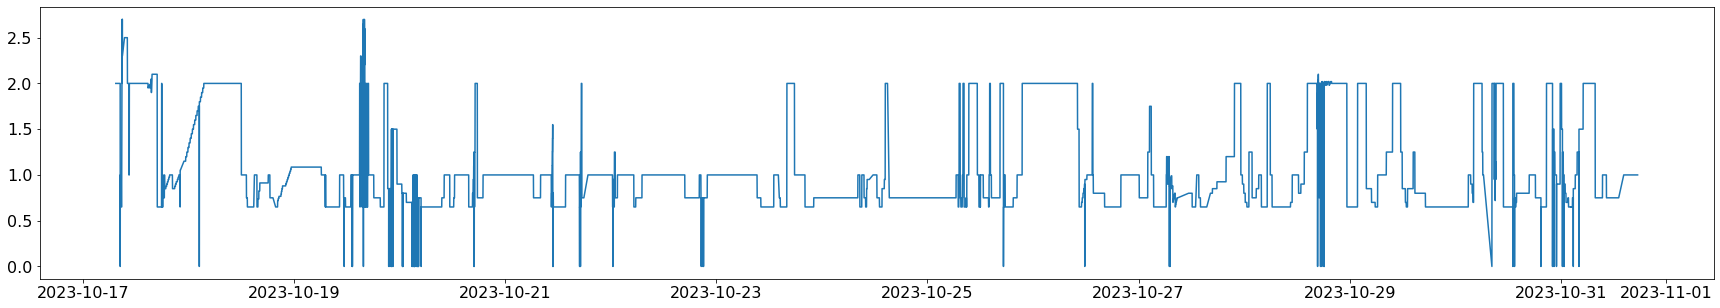

In [54]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(df.timestamp, df.Ekin)

In [55]:
df_ekin = df.copy()

In [58]:
merge_df = pd.merge_asof(df_gain_intensity, df_ekin, on='timestamp', direction='nearest')
df = merge_df[['timestamp', 'gain','intensity', 'Ekin']]

# Final DF

In [59]:
df.head(3)

timestamp  gain  intensity      Ekin
0 2023-10-17 07:29:52.851   0.2        107  2.000021
1 2023-10-17 07:30:50.451   0.2         23  2.000021
2 2023-10-17 07:31:48.051   0.2         34  2.000021

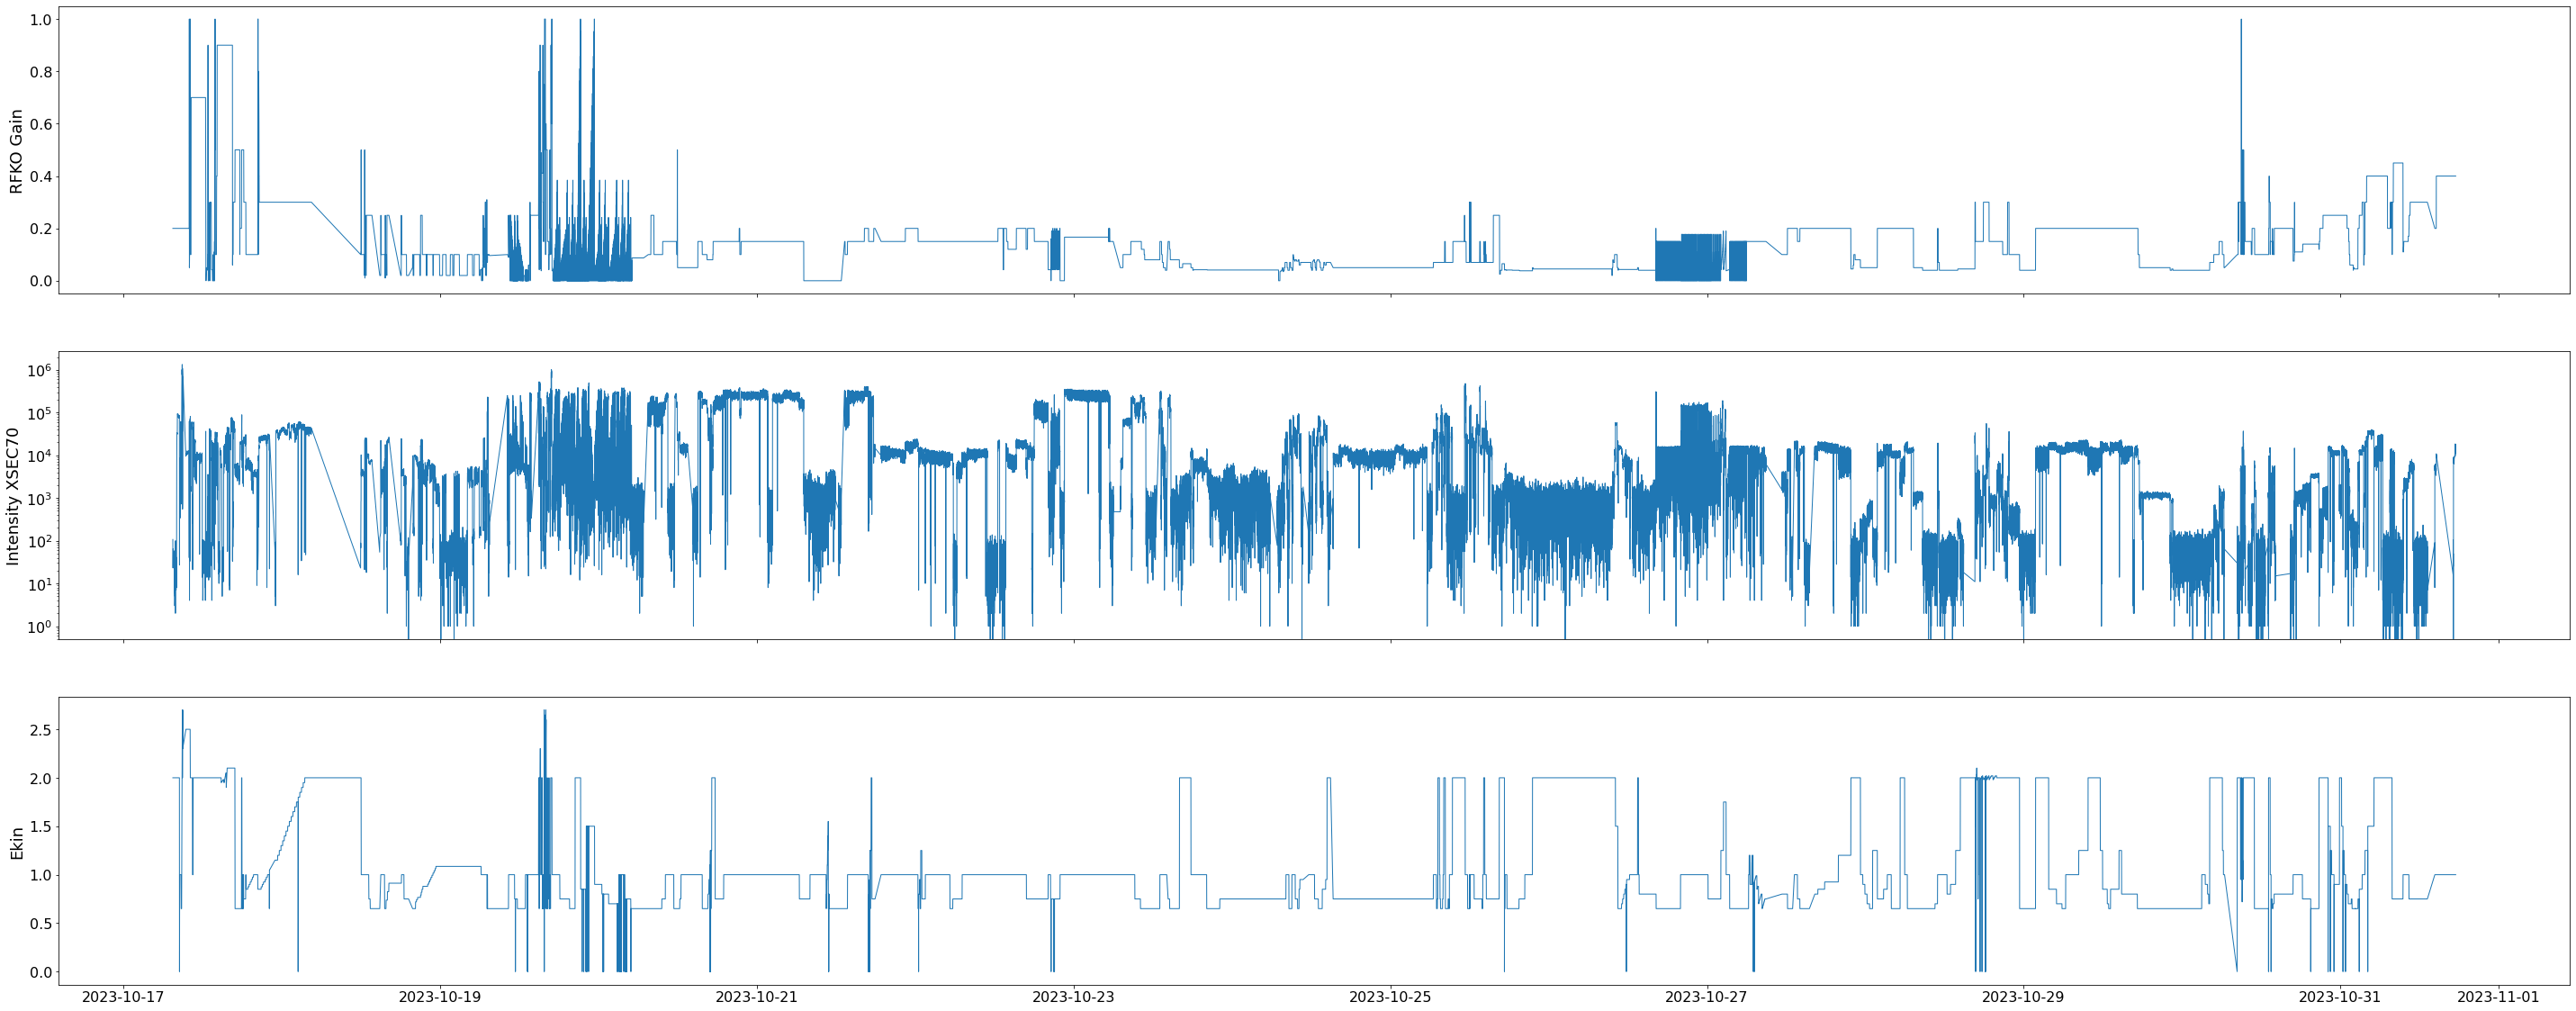

In [82]:
fig, ax = plt.subplots(3,1, figsize=(50,20), sharex=True)
ax[0].plot(df.timestamp, df.gain, label="RFKO gain", lw=1)
ax[1].plot(df.timestamp, df.intensity, label="Intensity XSEC70", lw=1)
ax[1].set_yscale("log")
ax[2].plot(df.timestamp, df.Ekin, label="Ekin", lw=1)

ax[0].set_ylabel("RFKO Gain")
ax[1].set_ylabel("Intensity XSEC70")
ax[2].set_ylabel("Ekin")

plt.savefig("hearts_nov_23_run_intensity_gain_ekin.png", facecolor='white', transparent=False, dpi = 200, bbox_inches='tight')